## Coursework from Deep Learning With Python by Francois Chollet.

## We will work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews (sequences of words have been turned into sequences of integers, where each integer stands for a specific word in a dictionary), for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

In [72]:
# Loading the IMDB dataset

from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## The argument num_words=10000 means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size.

## The variables train_data and test_data are lists of reviews; each review is a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [73]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [74]:
train_labels[0]

1

## Because you’re restricting yourself to the top 10,000 most frequent words, no word index will exceed 10,000:

In [75]:
max([max(sequence) for sequence in train_data])

9999

# Preparing the data

## You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:
## Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors (the Embedding layer).

## Or, One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

## Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.

In [76]:
# Encoding the integer sequences into a binary matrix

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [77]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

## You should also vectorize your labels, which is straightforward.

In [78]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
# Now the data is ready to be fed into a neural network.

# Building your network

## The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup you’ll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activations: Dense(16, activation='relu').

## The intermediate layers will use relu as their activation function, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”: how likely the review is to be positive). A relu (rectified linear unit) is a function meant to zero out negative values, whereas a sigmoid “squashes” arbitrary values into the [0, 1] interval, outputting something that can be interpreted as a probability.

In [79]:
# The model definition

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Finally, you need to choose a loss function and an optimizer. Because you’re facing a binary classification problem and the output of your network is a probability (you end your network with a single-unit layer with a sigmoid activation), it’s best to use the binary_crossentropy loss. It isn’t the only viable choice: you could use, for instance, mean_squared_error. But crossentropy is usually the best choice when you’re dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

## Here’s the step where you configure the model with the rmsprop optimizer and the binary_crossentropy loss function. Note that you’ll also monitor accuracy during training.

In [80]:
# Compiling the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

## Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss function or metric function. This former can be done by passing an optimizer class instance as the optimizer argument:

In [81]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

# Validating your approach

## In order to monitor during training the accuracy of the model on data it has never seen before, you’ll create a validation set by setting apart 10,000 samples from the original training data.

In [82]:
# Setting aside a validation set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## You’ll now train the model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At the same time, you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the validation_data argument.

## Note that the call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let’s look at it:

In [83]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 51ms/step - loss: 0.5202 - acc: 0.7859 - val_loss: 0.4042 - val_acc: 0.8552
Epoch 2/20
30/30 [==============================] - 1s 33ms/step - loss: 0.3148 - acc: 0.9043 - val_loss: 0.3106 - val_acc: 0.8886
Epoch 3/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2288 - acc: 0.9282 - val_loss: 0.3128 - val_acc: 0.8738
Epoch 4/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1772 - acc: 0.9457 - val_loss: 0.2814 - val_acc: 0.8869
Epoch 5/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1436 - acc: 0.9548 - val_loss: 0.2804 - val_acc: 0.8889
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1199 - acc: 0.9632 - val_loss: 0.3079 - val_acc: 0.8792
Epoch 7/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0961 - acc: 0.9716 - val_loss: 0.3169 - val_acc: 0.8824
Epoch 8/20
30/30 [==============================] - 1s 33ms/step - loss: 0.0820 - a

In [84]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## The dictionary contains four entries: one per metric that was being monitored during training and during validation. In the following two listing, let’s use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy

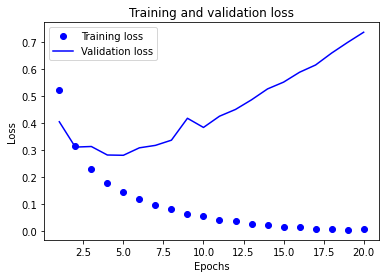

In [85]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

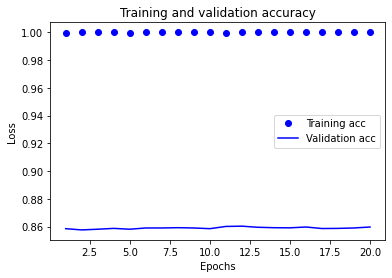

In [86]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Yours might be different!

## As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient descent optimization—the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourthish epoch, and flat for the accuracy. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is overfitting: after the second epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

## In this case, to prevent overfitting, you could stop training after five epochs. In general, you can use a range of techniques to mitigate overfitting.



In [87]:
# Retraining a model from scratch

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 27ms/step - loss: 0.4502 - accuracy: 0.8246
Epoch 2/4
49/49 [==============================] - 1s 26ms/step - loss: 0.2570 - accuracy: 0.9090
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.1965 - accuracy: 0.9291
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3004 - accuracy: 0.8816


In [88]:
results

[0.3004418909549713, 0.881600022315979]

## This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.